In [45]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [46]:
df = pd.read_csv('clean_tweets.csv')

In [47]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['sentiment'] = df['sentiment'].map({0:0,4:1})

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
sentiment    1600000 non-null int64
text         1596714 non-null object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [49]:
df.dropna(inplace=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596714 entries, 0 to 1599999
Data columns (total 2 columns):
sentiment    1596714 non-null int64
text         1596714 non-null object
dtypes: int64(1), object(1)
memory usage: 36.5+ MB


## Train/ Dev/ Test Split

We will split the data into three sections: train, development and test. Our chosen ratio is 98/1/1 i.e. 98% for the training set, 1% for the development set and 1% for the testing set.
* Train set: The dataset used for learning
* Development Set: A validation/development dataset is a sample of data held back from training your model that is used to give an estimate of model skill while tuning model’s hyperparameters.
* Test Set: The dataset used to assess the performance of a model.


In [51]:
from sklearn.model_selection import train_test_split

In [52]:
x = df['text'] #define all other columns except the target variable
y = df['sentiment'] #define the target variable

x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size = 0.02, random_state = 42)

x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, 
                                                              test_size = 0.5, random_state = 42)

In [53]:
print("Training set has {0} entries, where {1:.2f} are positive and {2:.2f} are negative".
      format(len(x_train),len(x_train[y_train==1])/len(x_train)*100, len(x_train[y_train==0])/len(x_train)*100))
print("Validation set has {0} entries, where {1:.2f} are positive and {2:.2f} are negative".
      format(len(x_validation),len(x_validation[y_validation==1])/len(x_validation)*100, 
             len(x_validation[y_validation==0])/len(x_validation)*100))
print("Testing set has {0} entries, where {1:.2f} are positive and {2:.2f} are negative".
      format(len(x_test),len(x_test[y_test==1])/len(x_test)*100, 
             len(x_test[y_test==0])/len(x_test)*100))

Training set has 1564779 entries, where 49.99 are positive and 50.01 are negative
Validation set has 15967 entries, where 49.82 are positive and 50.18 are negative
Testing set has 15968 entries, where 50.33 are positive and 49.67 are negative


## Baseline

### TextBlob

We will use the sentiment analysis function of TextBlob as baseline for our project. It will provide us a point of reference to compare our future models.

In [54]:
from textblob import TextBlob

In [55]:
tbresult = []
for i in x_validation:
    tbresult.append(TextBlob(i).sentiment.polarity)

In [56]:
tbpred = []
for i in tbresult:
    if i<0:
        tbpred.append(0)
    else:
        tbpred.append(1)    

In [57]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [58]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'], columns=['predicted_positive', 'predicted_negative'])
print("Accuracy score: {0:.2f} %".format(accuracy_score(y_validation, tbpred)*100))

Accuracy score: 61.41 %


In [59]:
print("Confusion Matrix")
print(confusion)

Confusion Matrix
          predicted_positive  predicted_negative
positive                7136                 818
negative                5344                2669


In [60]:
print("Classification Report")
print(classification_report(y_validation, tbpred))

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.33      0.46      8013
           1       0.57      0.90      0.70      7954

   micro avg       0.61      0.61      0.61     15967
   macro avg       0.67      0.62      0.58     15967
weighted avg       0.67      0.61      0.58     15967



Hence, TextBlob sentiment analysis yielded 61.41% accuracy on the validation set.

## Feature Extraction

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

Pipeline class allows sticking multiple processes into a single scikit-learn estimator.

In [62]:
null_accuracy = 0
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test==0])/len(x_test)>0.5:
        null_accuracy = len(x_test[y_test==0])/len(x_test)
    else:
        null_accuracy = 1 - len(x_test[y_test==0])/len(x_test)
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("Null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("Accuracy: {0:.2f}%".format(accuracy*100))
    if accuracy>null_accuracy:
        print("Model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy==null_accuracy:
        print("Model has the same accuracy as null accuracy")
    else:
        print("Model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("Train and test time: {0:.2f}s".format(train_test_time))
    print("-"*50)
    return accuracy, train_test_time

In [63]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000, 100001, 10000)

In [64]:
def nfeature_accuracy_checker(vectorizer = cvec, n_features = n_features, stop_words = None, 
                              ngram_range = (1,1), classifier = lr):
    result = []
    print(classifier, "\n")
    for n in n_features:
        vectorizer.set_params(stop_words = stop_words, max_features = n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])
        print("Validation result for {0} features".format(n))
        nfeature_accuracy, ttime = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n, nfeature_accuracy, ttime))
    return result

# Unigram

## Without stop words

In [65]:
%%time
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_unigram = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Validation result for 10000 features


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.27%
Model is 27.08% more accurate than null accuracy
Train and test time: 95.82s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 50.18%
Accuracy: 77.52%
Model is 27.33% more accurate than null accuracy
Train and test time: 112.32s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 50.18%
Accuracy: 77.54%
Model is 27.36% more accurate than null accuracy
Train and test time: 110.65s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 50.18%
Accuracy: 77.52%
Model is 27.34% more accurate than null accuracy
Train and test time: 100.34s
--------------------------------------------------
Validation result for 50000 features
Null accuracy: 50.18%
Accuracy: 77.50%
Model is 27.32% more accurate than null accuracy
Train and test time: 94.56s
--------------------------------------------------
Validation res

## With Stop Words

In [66]:
%%time
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_unigram_stop = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Validation result for 10000 features
Null accuracy: 50.18%
Accuracy: 79.73%
Model is 29.55% more accurate than null accuracy
Train and test time: 122.31s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 50.18%
Accuracy: 79.90%
Model is 29.71% more accurate than null accuracy
Train and test time: 184.95s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 50.18%
Accuracy: 79.98%
Model is 29.80% more accurate than null accuracy
Train and test time: 209.01s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 50.18%
Accuracy: 80.02%
Model i

In [15]:
term_freq_df = pd.read_csv('term_freq_data.csv', index_col = 0)
term_freq_df.head()

,negative,positive,total
word,,,
aa,168,97,265
aaa,97,55,152
aaaa,45,29,74
aaaaa,26,12,38
aaaaaa,16,12,28


In [16]:
term_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271306 entries, aa to zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
Data columns (total 3 columns):
negative    271306 non-null int64
positive    271306 non-null int64
total       271306 non-null int64
dtypes: int64(3)
memory usage: 8.3+ MB


In [17]:
term_freq_df.sort_values(by='total', ascending=False).head(10)

,negative,positive,total
word,,,
to,313185,252600,565785
the,257953,266161,524114
my,190805,125981,316786
it,157491,147841,305332
and,153985,149692,303677
you,103865,198274,302139
not,196637,87771,284408
is,133533,111325,244858
in,115628,101297,216925


In [42]:
from sklearn.feature_extraction import text

In [19]:
a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

Hence, all the most frequent words are in the sklearn stopwords list.

In [20]:
my_stop_words = a

Hence, I am running the model three times: first with stop words removal, second with custom stop words removal and third with stop words. First and third have already been done above.

## With custom stopwords

In [43]:
%%time
print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS\n")
feature_result_wocw = nfeature_accuracy_checker(stop_words = my_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Validation result for 10000 features


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 78.64%
Model is 28.46% more accurate than null accuracy
Train and test time: 137.90s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 50.18%
Accuracy: 79.13%
Model is 28.94% more accurate than null accuracy
Train and test time: 166.24s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 50.18%
Accuracy: 78.99%
Model is 28.81% more accurate than null accuracy
Train and test time: 192.24s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 50.18%
Accuracy: 79.08%
Model is 28.90% more accurate than null accuracy
Train and test time: 212.84s
--------------------------------------------------
Validation result for 50000 features
Null accuracy: 50.18%
Accuracy: 79.07%
Model is 28.88% more accurate than null accuracy
Train and test time: 239.77s
--------------------------------------------------
Validation r

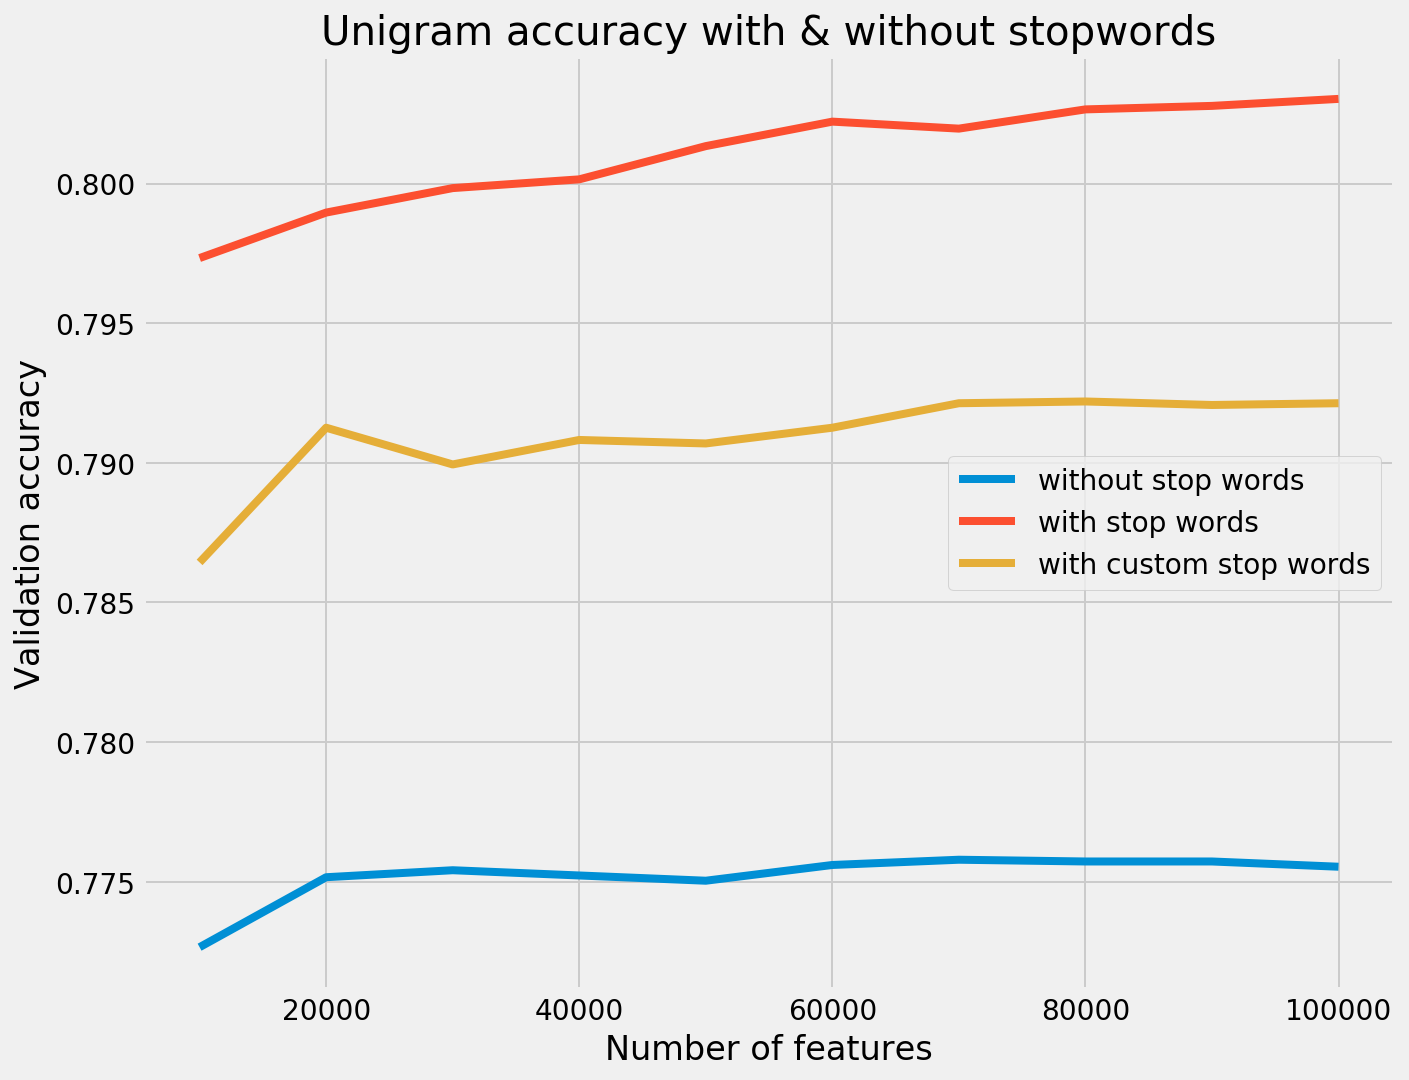

In [69]:
feature_plot_ug = pd.DataFrame(feature_result_unigram, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_wstop = pd.DataFrame(feature_result_unigram_stop, columns=['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_stopcw = pd.DataFrame(feature_result_wocw, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])
plt.figure(figsize=(10, 8))
plt.plot(feature_plot_ug.nfeatures, feature_plot_ug.validation_accuracy, label='without stop words')
plt.plot(feature_plot_wstop.nfeatures, feature_plot_wstop.validation_accuracy, label='with stop words')
plt.plot(feature_plot_stopcw.nfeatures, feature_plot_stopcw.validation_accuracy, label='with custom stop words')
plt.title('Unigram accuracy with & without stopwords')
plt.xlabel('Number of features')
plt.ylabel('Validation accuracy')
plt.legend()

Hence, removing stop words did not improve the performance of the model. In this setting, keeping the stopwords improve the model performance.

## Bigram with stop words

In [70]:
%%time
print("RESULT FOR BIGRAM\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1,2))

RESULT FOR BIGRAM

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Validation result for 10000 features


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.62%
Model is 30.44% more accurate than null accuracy
Train and test time: 287.85s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 50.18%
Accuracy: 81.29%
Model is 31.10% more accurate than null accuracy
Train and test time: 321.10s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 50.18%
Accuracy: 81.68%
Model is 31.50% more accurate than null accuracy
Train and test time: 332.50s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 50.18%
Accuracy: 82.00%
Model is 31.82% more accurate than null accuracy
Train and test time: 374.88s
--------------------------------------------------
Validation result for 50000 features
Null accuracy: 50.18%
Accuracy: 82.02%
Model is 31.83% more accurate than null accuracy
Train and test time: 471.11s
--------------------------------------------------
Validation r

## Trigram with stop words

In [71]:
%%time
print("RESULT FOR TRIGRAM\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1,3))

RESULT FOR TRIGRAM

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Validation result for 10000 features
Null accuracy: 50.18%
Accuracy: 80.46%
Model is 30.27% more accurate than null accuracy
Train and test time: 375.35s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 50.18%
Accuracy: 81.21%
Model is 31.03% more accurate than null accuracy
Train and test time: 413.71s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 50.18%
Accuracy: 81.55%
Model is 31.36% more accurate than null accuracy
Train and test time: 481.24s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 50.18%
Accuracy: 81.86%
Model is 31.68% more ac

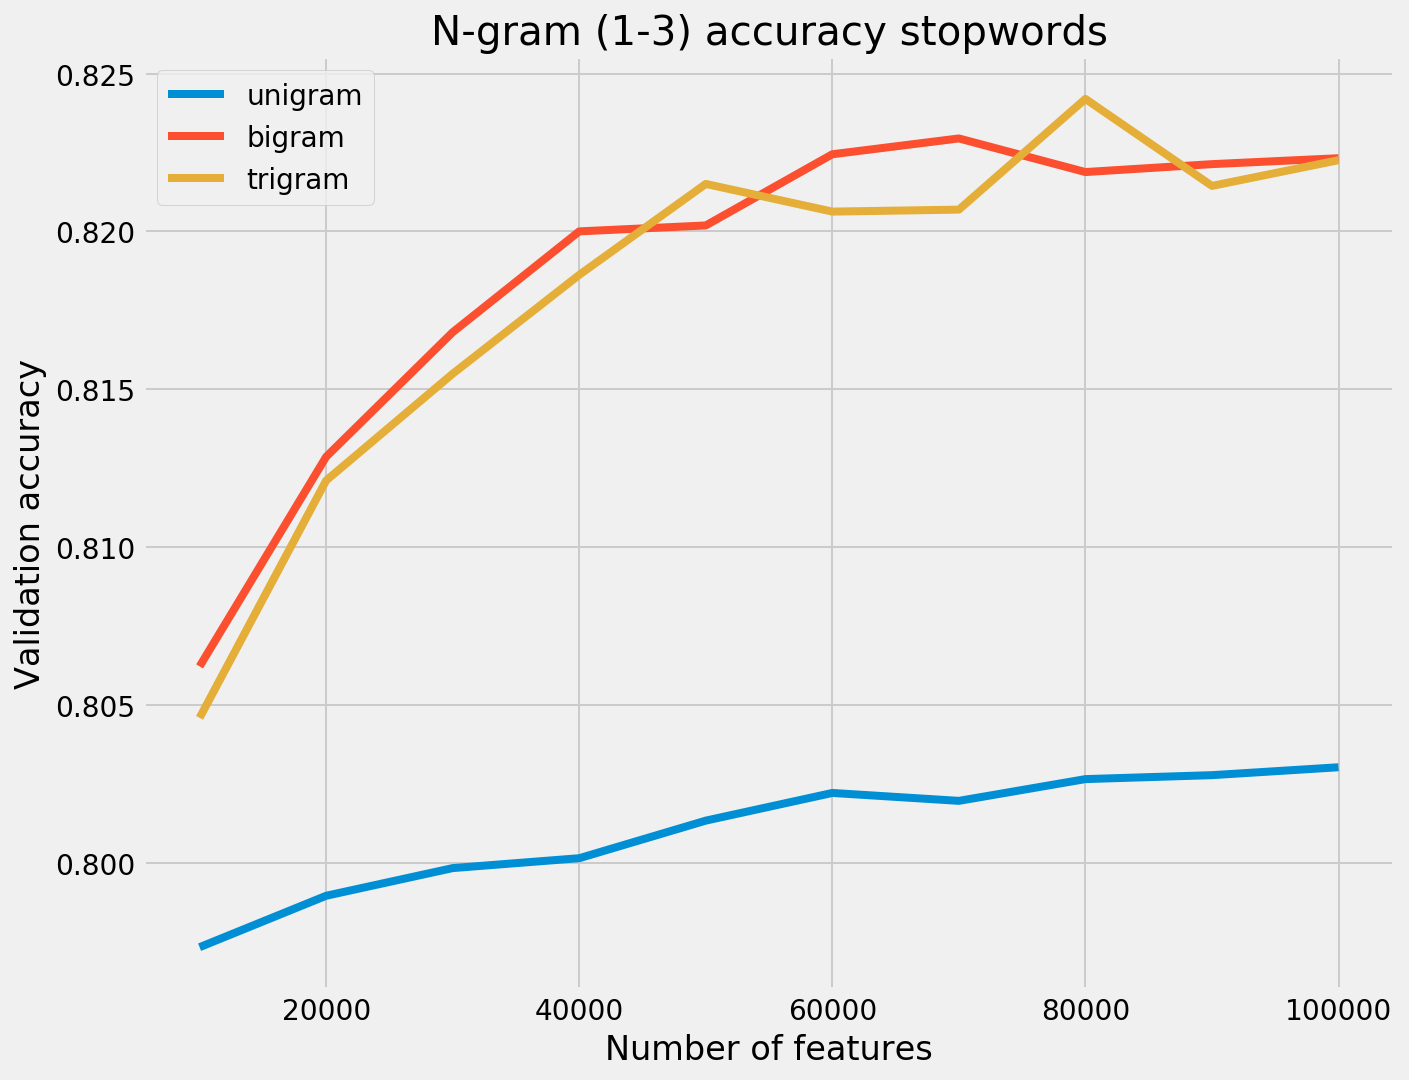

In [72]:
feature_plot_ug = pd.DataFrame(feature_result_unigram_stop, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_bg = pd.DataFrame(feature_result_bg, columns=['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_tg = pd.DataFrame(feature_result_tg, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])
plt.figure(figsize=(10, 8))
plt.plot(feature_plot_ug.nfeatures, feature_plot_ug.validation_accuracy, label='unigram')
plt.plot(feature_plot_bg.nfeatures, feature_plot_bg.validation_accuracy, label='bigram')
plt.plot(feature_plot_tg.nfeatures, feature_plot_tg.validation_accuracy, label='trigram')
plt.title('N-gram (1-3) accuracy stopwords')
plt.xlabel('Number of features')
plt.ylabel('Validation accuracy')
plt.legend()